In [3]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Image dimensions
img_width, img_height = 220, 220

# Dataset paths
train_data_dir = "data/train"
validation_data_dir = "data/validation"
nb_train_samples = 50
nb_validation_samples = 50
batch_size = 16
epochs = 3

# Load the VGG19 model without the top fully connected layers
model = applications.VGG19(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the first 16 layers to prevent training
for layer in model.layers[:16]:
    layer.trainable = False

# Adding custom layers on top of VGG19
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

# Define the final model
model_final = Model(inputs=model.input, outputs=predictions)

# Compile the model
model_final.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    fill_mode="nearest",
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    fill_mode="nearest",
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30
)

# Generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

# Define callbacks
checkpoint = ModelCheckpoint(
    "vgg19_best_model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto'
)

# Train the model
history = model_final.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

# Save the final model
model_final.save("vgg19_final_model.h5")


Found 1914 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Epoch 1/3
3/3 [==============================] - ETA: 0s - loss: 2.6521 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.54167, saving model to vgg19_best_model.h5
3/3 [==============================] - 53s 19s/step - loss: 2.6521 - accuracy: 0.5000 - val_loss: 0.6764 - val_accuracy: 0.5417
Epoch 2/3
3/3 [==============================] - ETA: 0s - loss: 2.1174 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.54167 to 0.64583, saving model to vgg19_best_model.h5
3/3 [==============================] - 44s 18s/step - loss: 2.1174 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.6458
Epoch 3/3
3/3 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 0.64583
3/3 [==============================] - 42s 17s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.4792


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


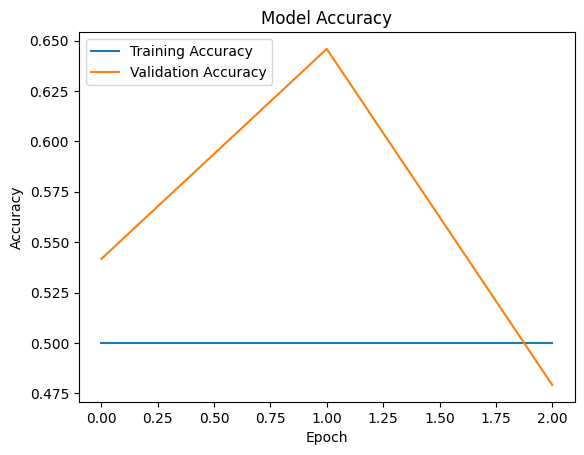

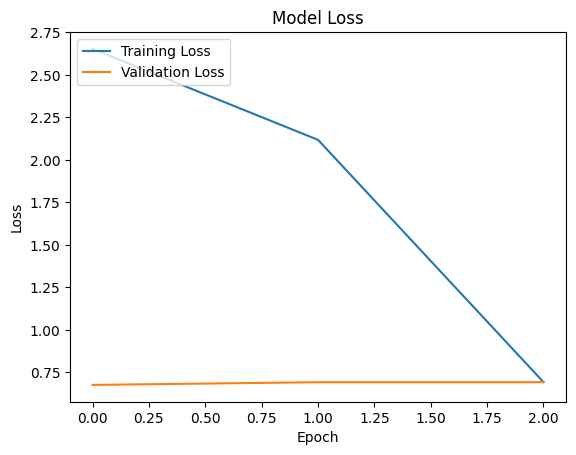

In [5]:
import matplotlib.pyplot as plt

# Ensure inline plotting for Jupyter Notebooks
%matplotlib inline

# List all data in history
print(history.history.keys())

# Plot model accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot model loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()